# Molecular dynamics application example

Go to:
    
  - [Notebook configuration](md_example.ipynb#Notebook-configuration)
  - [Helper functions](md_example.ipynb#Helper-functions)
  - [The C-type lectin receptor langerin](md_example.ipynb#The-C-type-lection-receptor-langerin)
  - [Clustering root data](md_example.ipynb#Clustering-root-data)
  - [Semi-automatic hierarchical clustering](md_example.ipynb#Semi-automatic-hierarchical-clustering)

## Notebook configuration

In [1]:
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import sklearn
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import KDTree
from tqdm.notebook import tqdm

import cnnclustering
from cnnclustering import cluster, plot, hooks

Print Python and package version information:

In [2]:
# Version information
print("Python: ", *sys.version.split("\n"))

print("Packages:")
for package in [mpl, np, sklearn, cnnclustering]:
    print(f"    {package.__name__}: {package.__version__}")

Python:  3.8.8 (default, Mar 11 2021, 08:58:19)  [GCC 8.3.0]
Packages:
    matplotlib: 3.3.4
    numpy: 1.20.1
    sklearn: 0.24.1
    cnnclustering: 0.4.3


We use [Matplotlib](https://matplotlib.org/) to create plots. The `matplotlibrc` file in the root directory of the `CommonNNClustering` repository is used to customize the appearance of the plots.

In [3]:
# Matplotlib configuration
mpl.rc_file(
    "../../matplotlibrc",
    use_default_template=False
)

In [4]:
# Axis property defaults for the plots
ax_props = {
    "xlabel": None,
    "ylabel": None,
    "xticks": (),
    "yticks": (),
    "aspect": "equal"
}

## Helper functions

In [5]:
def draw_evaluate(clustering, axis_labels=False, plot_style="dots"):
    
    fig, Ax = plt.subplots(
        1, 3,
        figsize=(mpl.rcParams['figure.figsize'][0],
                 mpl.rcParams['figure.figsize'][1] * 0.5)
        )

    for dim in range(3):
        dim_ = (dim * 2, dim * 2 + 1)
        
        ax_props_ = {k: v for k, v in ax_props.items()}
        if axis_labels:
            ax_props_.update(
                {"xlabel": dim_[0] + 1, "ylabel": dim_[1] + 1}
            )

        _ = clustering.evaluate(
            ax=Ax[dim],
            plot_style=plot_style,
            ax_props=ax_props_,
            dim=dim_
            )
        
        Ax[dim].yaxis.get_label().set_rotation(0)

## The C-type lection receptor langerin

Let's read in some "real world" data for this example. We will work with a 6D projection from a classical MD trajectory of the C-type lectin receptor langerin that was generated by the dimension reduction procedure TICA.

In [6]:
langerin = cluster.Clustering(
    np.load("md_example/langerin_projection.npy", allow_pickle=True),
    alias="C-type lectin langerin"
    )

After creating a `Clustering` instance, we can print out basic information about the data. The projection comes in 116 parts of individual independent simulations. In total we have about 26,000 data points in this set representing 26 microseconds of simulation time at a sampling timestep of 1 nanoseconds.

In [7]:
print(langerin.info())

alias: 'C-type lectin langerin'
hierarchy_level: 0
access: coordinates
points: 26528
children: None


Dealing with six data dimensions we can still visualise the data quite well.

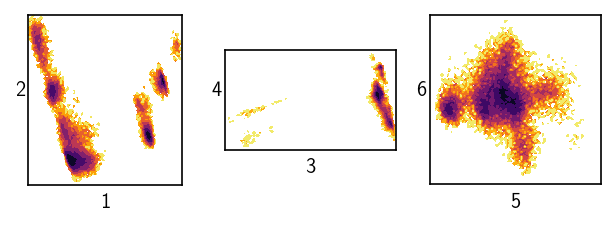

In [8]:
draw_evaluate(langerin, axis_labels=True, plot_style="contourf")

A quick look on the distribution of distances in the set gives us a first feeling for what might be a suitable value for the neighbour search radius *r*.

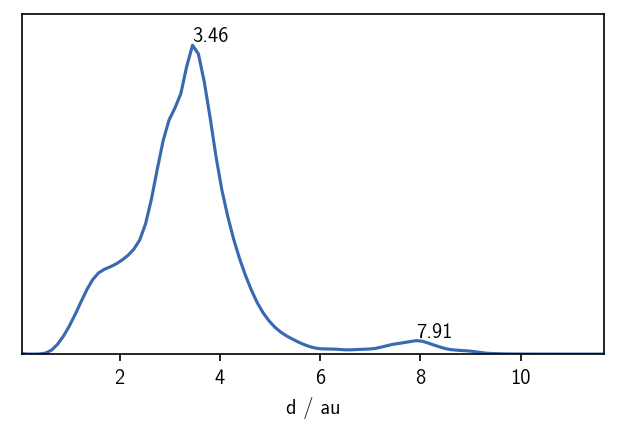

In [9]:
distances = pairwise_distances(
    langerin.input_data
)[np.triu_indices(langerin._input_data.n_points)].flatten().astype(np.float32)

fig, ax = plt.subplots()
_ = plot.plot_histogram(ax, distances, maxima=True, maxima_props={"order": 5})

In [10]:
# Free memory
%xdel distances

We can suspect that values of *r* of roughly 2 or lower should be a good starting point. The maximum in the distribution closest to 0 defines a reasonable value range for $r$. We can also get a feeling for what values *c* could take by checking the number of neighbours each point has for a given search radius.

In [11]:
min_n = []
max_n = []
mean_n = []


tree = KDTree(langerin.input_data)
r_list = np.arange(0.25, 3.25, 0.25)
for r in tqdm(r_list):
    n_neighbours = [
        x.shape[0]
        for x in tree.query_radius(
            langerin.input_data, r, return_distance=False
        )
    ]
    
    if r == 2.0:
        n_neighbours_highlight = np.copy(n_neighbours)
    
    min_n.append(np.min(n_neighbours))
    max_n.append(np.max(n_neighbours))
    mean_n.append(np.mean(n_neighbours))

  0%|          | 0/12 [00:00<?, ?it/s]

[(0.25, 3.0), Text(0.5, 0, '$r$'), Text(0, 0.5, '#neighbours')]

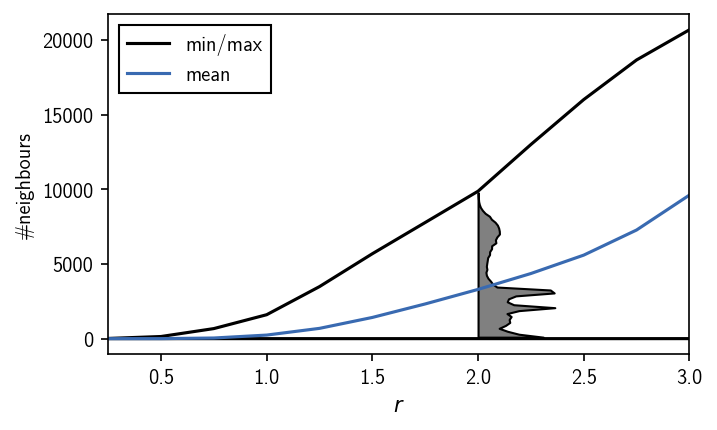

In [27]:
h, e = np.histogram(n_neighbours_highlight, bins=50, density=True)
e = (e[:-1] + e[1:]) / 2

fig, ax = plt.subplots()
# ax.plot([2.0, 2.0], (e[0], e[-1]), "k")
ax.fill_betweenx(
    e, np.full_like(e, 2.0), 2.0 + h * 1000,
    edgecolor="k", facecolor="gray"
)
min_line, = ax.plot(r_list, min_n, "k")
max_line, = ax.plot(r_list, max_n, "k")
mean_line, = ax.plot(r_list, mean_n)

ax.legend(
    [min_line, mean_line], ["min/max", "mean"],
    fancybox=False, framealpha=1, edgecolor="k"
)

ax.set(**{
    "xlim": (r_list[0], r_list[-1]),
    "xlabel": "$r$",
    "ylabel": "#neighbours",
})

In the radius value regime of 2 and higher the number of neighbours per point quickly approaches the number of points in the whole data set. We can interpret these plots as upper bounds (max: hard bound; mean: soft bound) for $c$ if $r$ varies. Values of $c$ much larger than say 5000 probably wont make to much sense for radii below around 2.0. If the radius cutoff is set to $r=1$, $c$ is already capped at a few hundreds. We can also see that for a radius of 2.0, a substantial amount of the data points have close to no neighbour at all. Care has to taken that we do not loose an interesting portion of the feature space here when this radius is used. 

## Clustering root data

Let's attempt a first clustering step with a relatively low density criterion (large *r* cutoff, low number of common neighbours *c*). When we cluster, we can judge the outcome by how many clusters we obtain and how many points end up as being classified as noise. For the first clustering steps, it can be a good idea to start with a low density cutoff and then increase it gradually (preferably by keeping $r$ constant and increasing $c$). As we choose higher density criteria the number of resulting clusters will rise and so will the noise level. We need to find the point where we yield a large number of (reasonably sized) clusters without loosing relevant information in the noise regions. Keep in mind that the ideal number of clusters and noise ratio are not definable and highly dependent on the nature of the data and your (subjective) expectation if there is no dedicated way of clustering validation. 

In [10]:
tree = KDTree(langerin.input_data)

In [18]:
r = 1.5

neighbourhoods = tree.query_radius(langerin.input_data, r, return_distance=False)
for n in neighbourhoods:
    n.sort()

langerin_neighbourhoods = cluster.Clustering(
    neighbourhoods,
    preparation_hook=hooks.prepare_neighbourhoods,
    registered_recipe_key="sorted_neighbourhoods"
)

In [54]:
langerin_neighbourhoods.fit(r, 2, member_cutoff=10)
langerin._labels = langerin_neighbourhoods._labels

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
26528     1.500     2         10        None      11        0.702     0.005     00:00:0.408
-----------------------------------------------------------------------------------------------



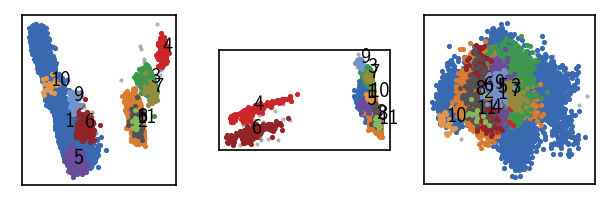

In [55]:
draw_evaluate(langerin)

We obtain a low number of noise points and a handful of clusters so we are at least not completely of track here with our initial guess on $r$. To get a better feeling for how the clustering changes with higher density-thresholds, one could scan a few more parameter combinations.

In [31]:
r = 1.5

for c in tqdm(np.arange(0, 105, 1)):
    langerin_neighbourhoods.fit(r, c, member_cutoff=10, v=False)
    langerin._summary.append(langerin_neighbourhoods._summary[-1])

  0%|          | 0/105 [00:00<?, ?it/s]

In [34]:
df = langerin.summary.to_DataFrame()
df[:10]

n_points  radius_cutoff  cnn_cutoff  member_cutoff  max_clusters  \
0     26528            1.5           0             10          <NA>   
1     26528            1.5           1             10          <NA>   
2     26528            1.5           2             10          <NA>   
3     26528            1.5           3             10          <NA>   
4     26528            1.5           4             10          <NA>   
5     26528            1.5           5             10          <NA>   
6     26528            1.5           6             10          <NA>   
7     26528            1.5           7             10          <NA>   
8     26528            1.5           8             10          <NA>   
9     26528            1.5           9             10          <NA>   

   n_clusters  ratio_largest  ratio_noise  execution_time  
0          11       0.703935     0.002262        0.392356  
1          11       0.702955     0.004033        0.379377  
2          11       0.702201     0.005428        0.380070  
3          11       0.701372     0.006672        0.380684  
4          12       0.700317     0.007765        0.381347  
5          11       0.699940     0.009650        0.383584  
6          11       0.699337     0.010630        0.382752  
7          11       0.698809     0.011610        0.383833  
8          11       0.698206     0.012553        0.384226  
9          11       0.697603     0.013571        0.384882

[(0.0, 104.0),
 Text(0.5, 0, '$c$'),
 Text(0, 0.5, '#clusters'),

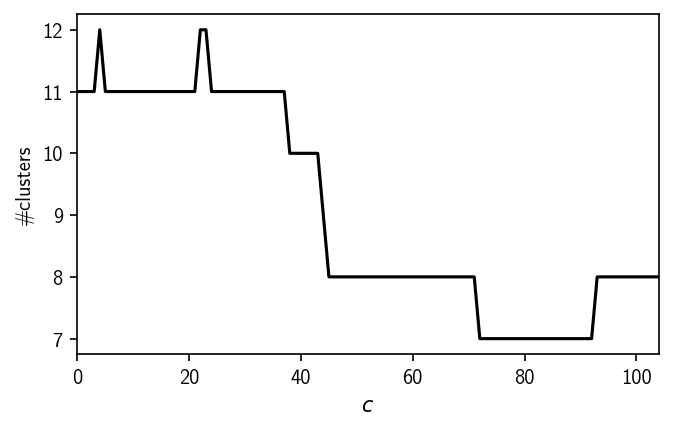

In [33]:
c_values = df["cnn_cutoff"].to_numpy()
n_cluster_values = df["n_clusters"].to_numpy()

fig, ax = plt.subplots()
ax.plot(c_values, n_cluster_values, "k")
ax.set(**{
    "xlim": (c_values[0], c_values[-1]),
    "xlabel": "$c$",
    "ylabel": "#clusters",
    "yticks": range(np.min(n_cluster_values), np.max(n_cluster_values) + 1)
    })

As we see here, increasing $c$ and therefore the density-threshold only yields less clusters which potentially means we are starting to loose information. We can use hierarchical clustering to freeze the obtained clustering and increase the density-threshold only for a portion of the data set.

To be sure, we can also double check the result with a somewhat larger radius to exclude that we already lost potential clusters with our first parameter combination. 

In [35]:
r = 2.5

neighbourhoods = tree.query_radius(langerin.input_data, r, return_distance=False)
for n in neighbourhoods:
    n.sort()

langerin_neighbourhoods = cluster.Clustering(
    neighbourhoods,
    preparation_hook=hooks.prepare_neighbourhoods,
    registered_recipe_key="sorted_neighbourhoods"
)

In [38]:
langerin._summary._list = []

In [39]:
for c in tqdm(np.arange(0, 105, 1)):
    langerin_neighbourhoods.fit(r, c, member_cutoff=10, v=False)
    langerin._summary.append(langerin_neighbourhoods._summary[-1])

  0%|          | 0/105 [00:00<?, ?it/s]

[(0.0, 104.0),
 Text(0.5, 0, '$c$'),
 Text(0, 0.5, '#clusters'),

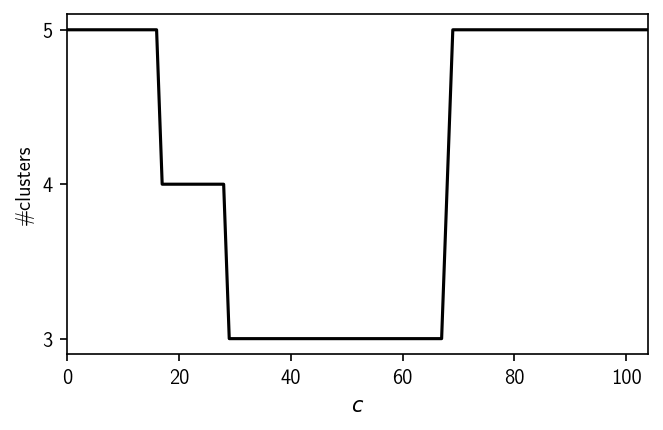

In [40]:
df = langerin.summary.to_DataFrame()

c_values = df["cnn_cutoff"].to_numpy()
n_cluster_values = df["n_clusters"].to_numpy()

fig, ax = plt.subplots()
ax.plot(c_values, n_cluster_values, "k")
ax.set(**{
    "xlim": (c_values[0], c_values[-1]),
    "xlabel": "$c$",
    "ylabel": "#clusters",
    "yticks": range(np.min(n_cluster_values), np.max(n_cluster_values) + 1)
    })

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
26528     2.500     1         None      None      5         0.981     0.000     00:00:1.469
-----------------------------------------------------------------------------------------------



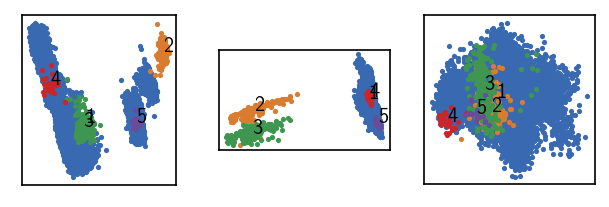

In [41]:
langerin_neighbourhoods.fit(r, 1)
langerin._labels = langerin_neighbourhoods._labels
draw_evaluate(langerin)

It looks like we obtain no additional cluster with the larger radius that is lost for the smaller one. For now we can deliberately stick with the smaller radius.

## Semi-automatic hierarchical clustering

We described rationally guided, manual hierarchical clustering in the [Hierarchical clustering basics](hierarchical_clustering_basics.ipynb) tutorial using the `isolate` formalism. Here we want to take the different approach of generating a cluster hierarchy more or less automatically for a given cluster parameter range. We will use the radius of $r=2$ from the last section and a grid of $c$ values to cluster subsequently with higher density-thresholds while we keep track of the change in the cluster label assignments.

In [42]:
tree = KDTree(langerin.input_data)

In [43]:
r = 1.5

neighbourhoods = tree.query_radius(langerin.input_data, r, return_distance=False)
for n in neighbourhoods:
    n.sort()

langerin_neighbourhoods = cluster.Clustering(
    neighbourhoods,
    preparation_hook=hooks.prepare_neighbourhoods,
    registered_recipe_key="sorted_neighbourhoods"
)

We will start at $c=2$ but we will also need to determine a reasonable endpoint. To check the deduction of an upper bound from the number-of-neioghbours plot in the last section, let's have a look at a clustering with a very high density-threshold.

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
26528     1.500     950       None      None      4         0.314     0.430     00:00:4.802
-----------------------------------------------------------------------------------------------



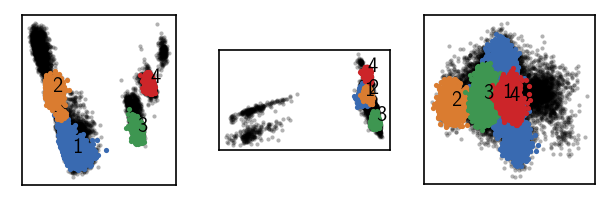

In [89]:
langerin_neighbourhoods.fit(r, 950)
langerin._labels = langerin_neighbourhoods._labels
draw_evaluate(langerin)

At this point, the clustering does yield only clusters that are shrinking with even higher values for $c$.

In [84]:
c_range = [
    int(2 * 1.2**x)
    for x in range(0, 35)
    if int(2 * 1.2**x) != int(2 * 1.2**(x-1))
]
print(c_range) 

[2, 3, 4, 5, 7, 8, 10, 12, 14, 17, 21, 25, 30, 36, 44, 53, 63, 76, 92, 110, 132, 158, 190, 228, 274, 329, 395, 474, 569, 683, 820, 984]


In [90]:
langerin_neighbourhoods.fit_hierarchical(
    r,
    c_range,
    member_cutoff=10
)

Running step 0     (r = 1.5, c = 2)
Running step 1     (r = 1.5, c = 3)
Running step 2     (r = 1.5, c = 4)
Running step 3     (r = 1.5, c = 5)
Running step 4     (r = 1.5, c = 7)
Running step 5     (r = 1.5, c = 8)
Running step 6     (r = 1.5, c = 10)
Running step 7     (r = 1.5, c = 12)
Running step 8     (r = 1.5, c = 14)
Running step 9     (r = 1.5, c = 17)
Running step 10    (r = 1.5, c = 21)
Running step 11    (r = 1.5, c = 25)
Running step 12    (r = 1.5, c = 30)
Running step 13    (r = 1.5, c = 36)
Running step 14    (r = 1.5, c = 44)
Running step 15    (r = 1.5, c = 53)
Running step 16    (r = 1.5, c = 63)
Running step 17    (r = 1.5, c = 76)
Running step 18    (r = 1.5, c = 92)
Running step 19    (r = 1.5, c = 110)
Running step 20    (r = 1.5, c = 132)
Running step 21    (r = 1.5, c = 158)
Running step 22    (r = 1.5, c = 190)
Running step 23    (r = 1.5, c = 228)
Running step 24    (r = 1.5, c = 274)
Running step 25    (r = 1.5, c = 329)
Running step 26    (r = 1.5, c = 395)

The resulting hierarchy of clusterings can be visualised either as a tree or pie plot.

(<Figure size 1875x1350 with 1 Axes>, <AxesSubplot:>)

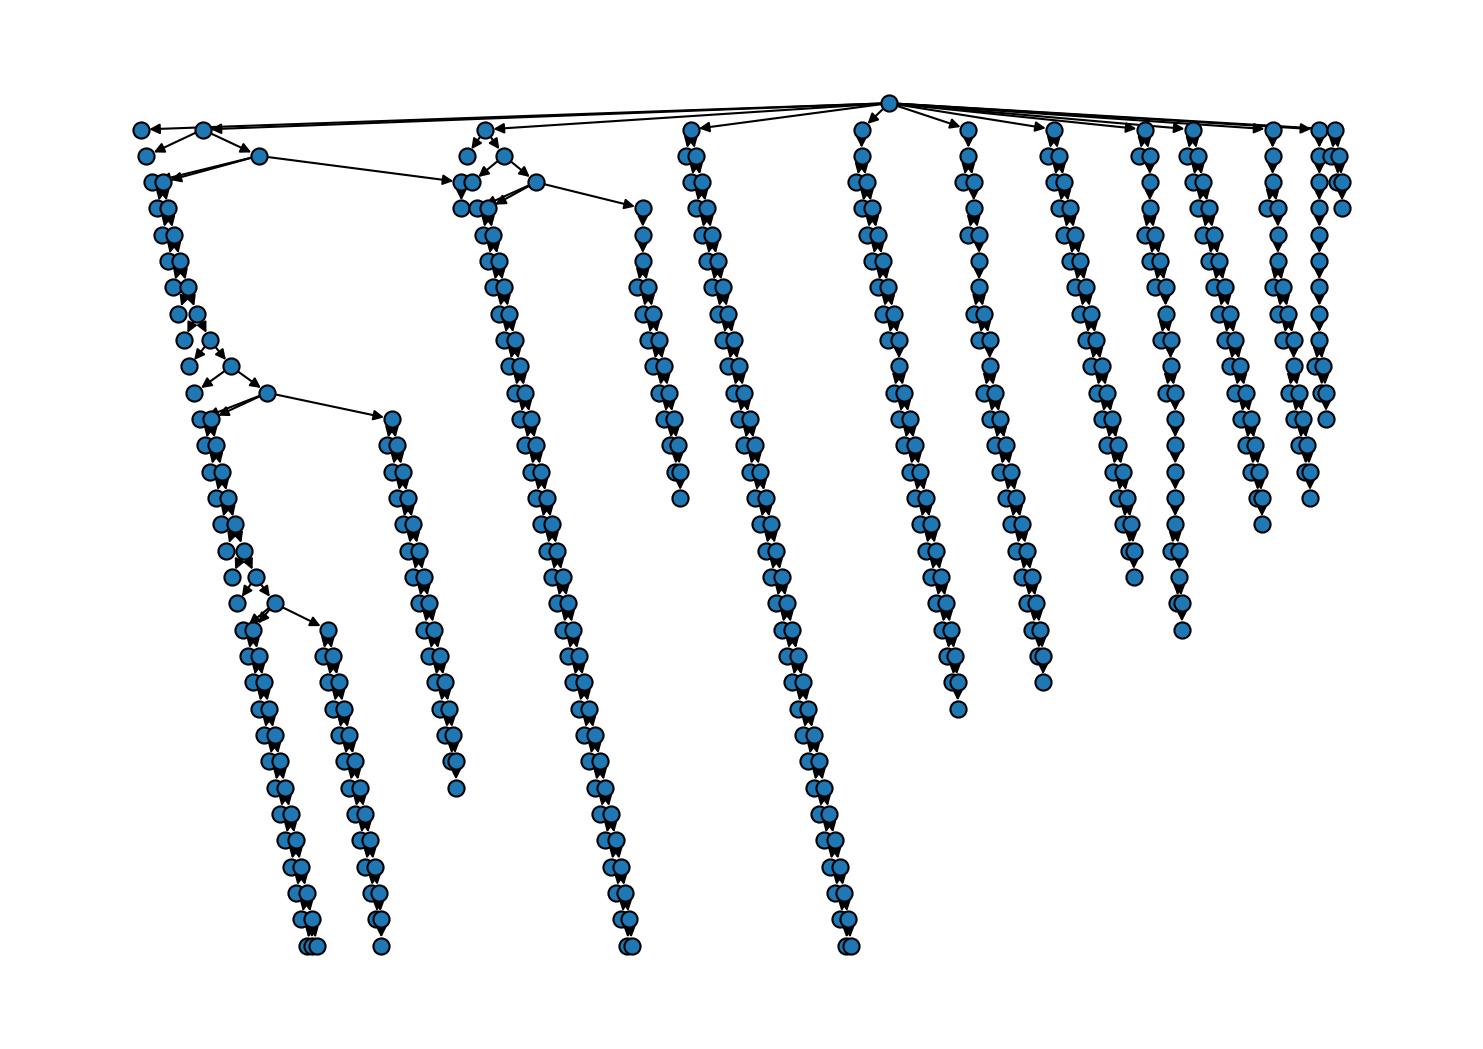

In [91]:
# Cluster hierarchy as tree diagram
#     (hierarchy level increasing from top to bottom)
fig, ax = plt.subplots(
    figsize=(
        mpl.rcParams["figure.figsize"][0] * 2.5,
        mpl.rcParams["figure.figsize"][1] * 3
    )
)
langerin_neighbourhoods.tree(
    ax=ax,
    draw_props={
        "node_size": 60,
        "node_shape": "o",
        "with_labels": False
    }
)

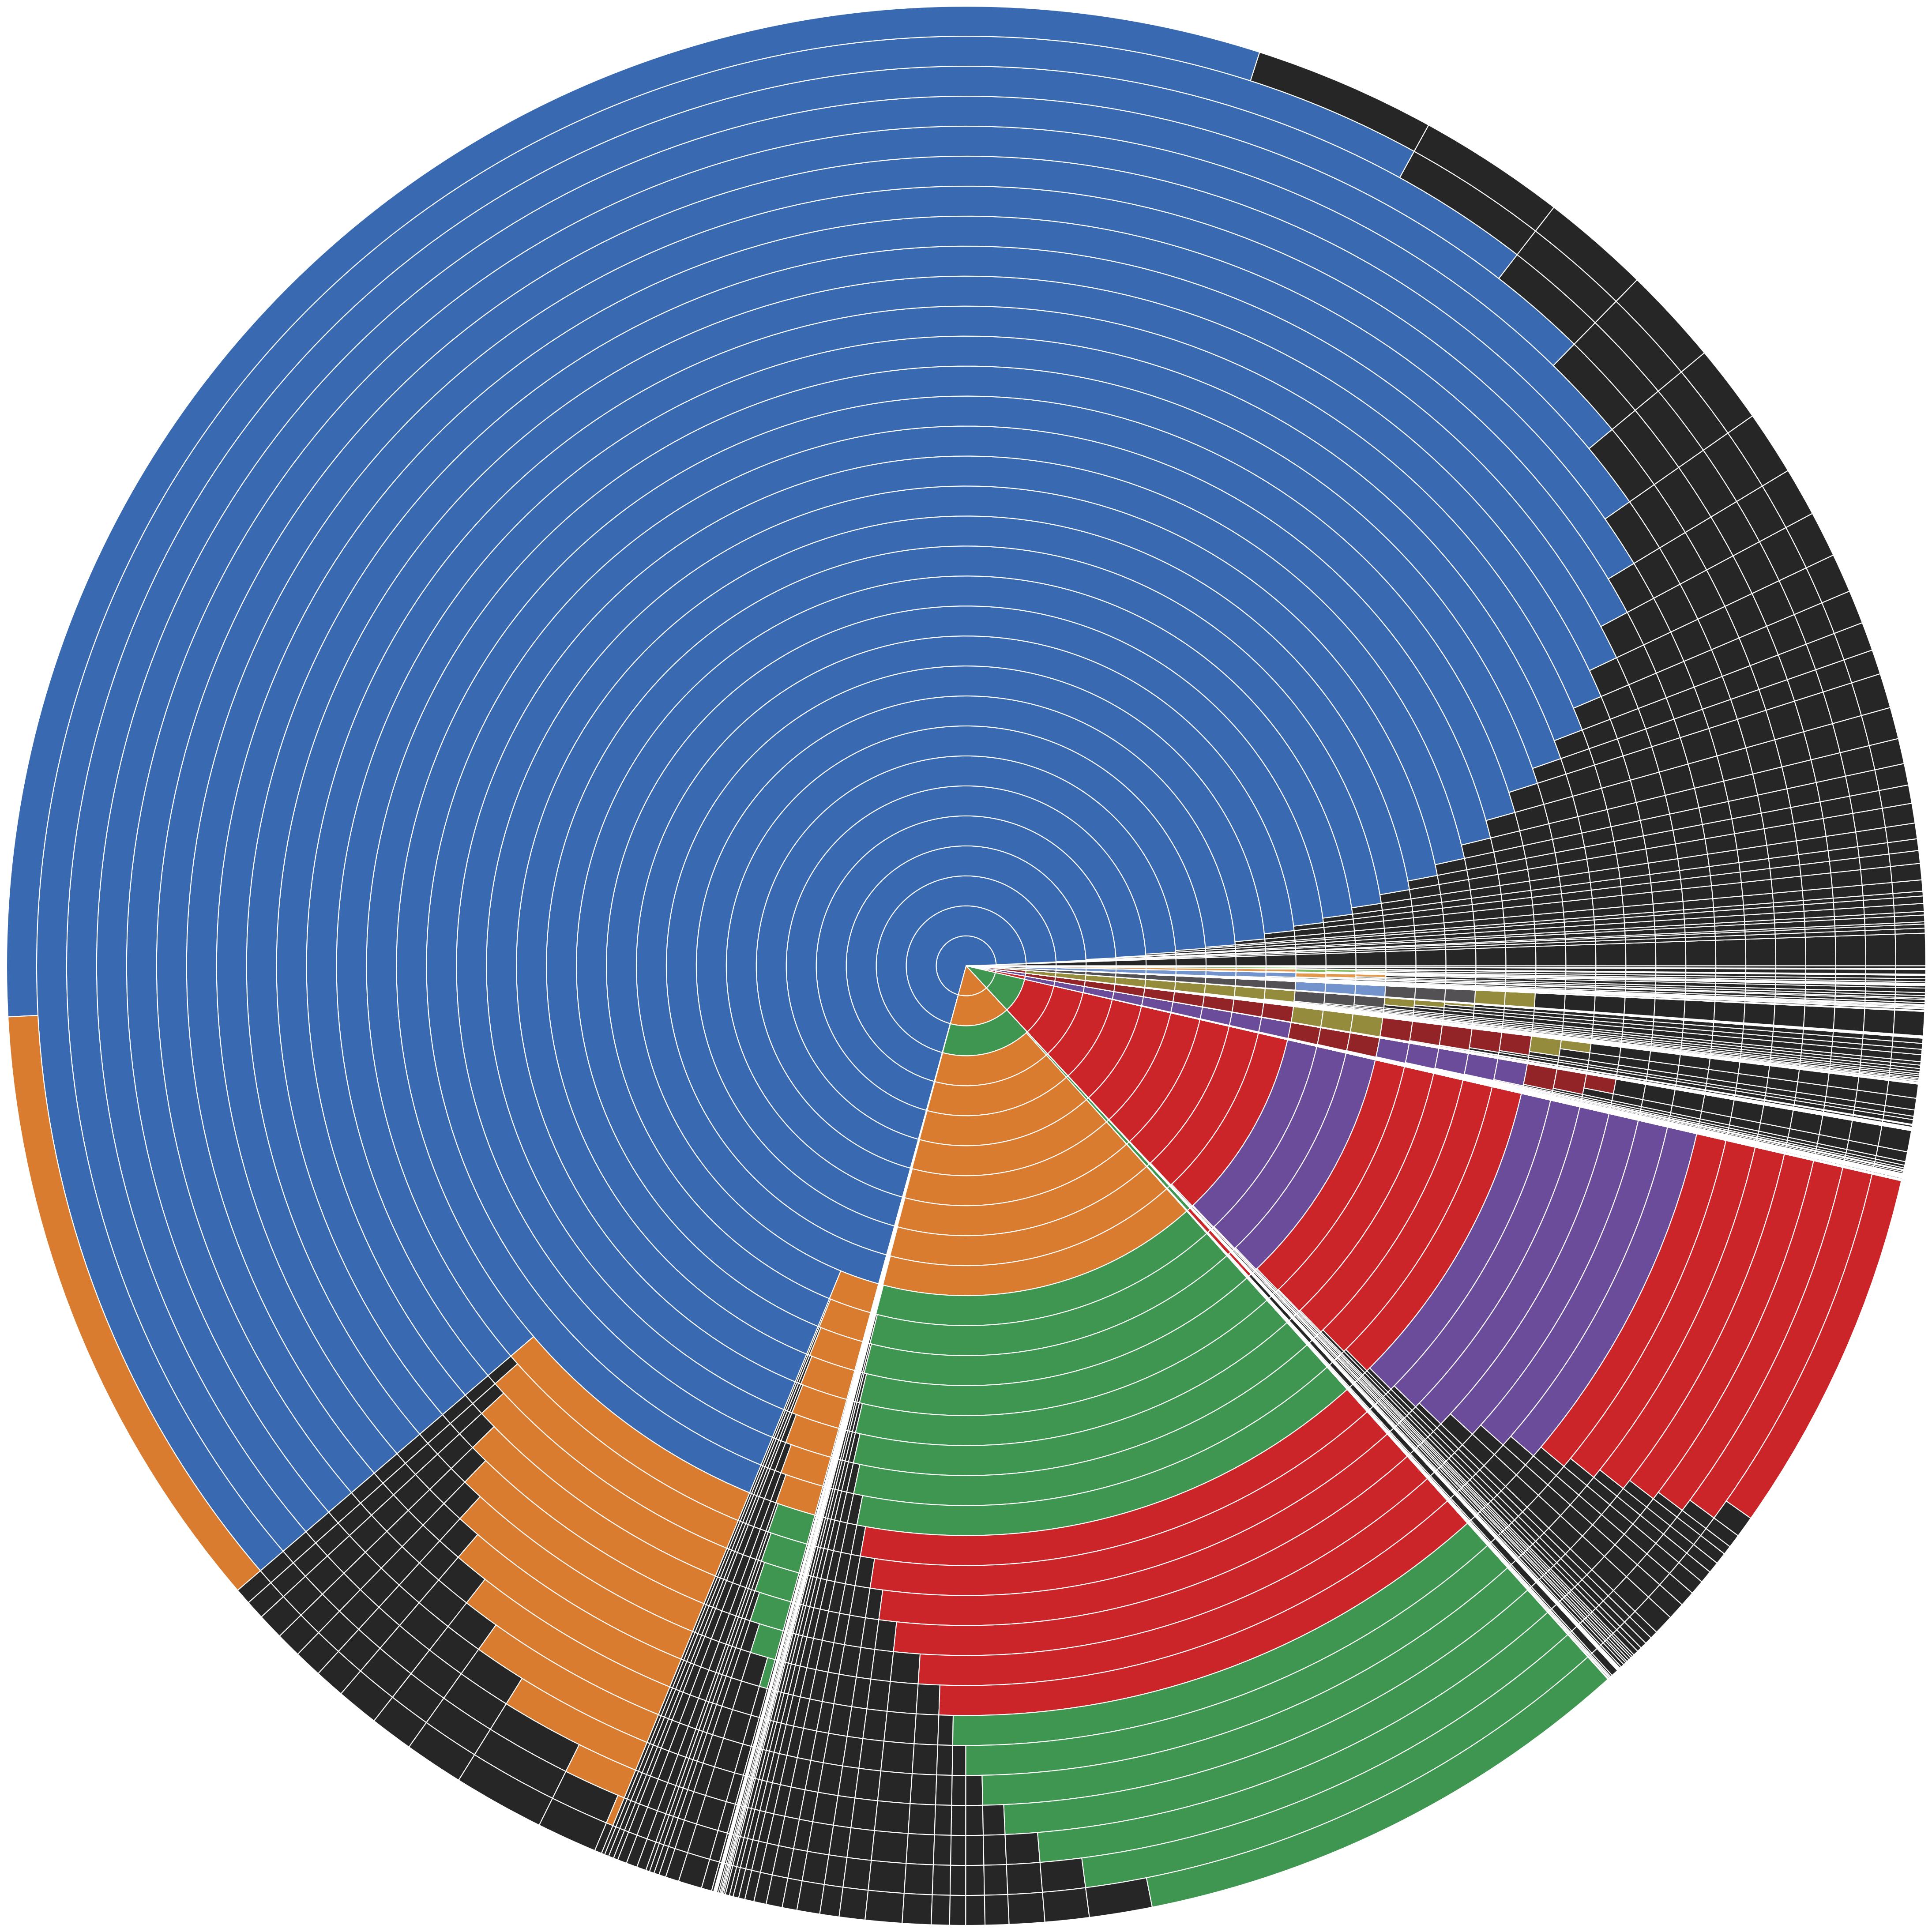

In [92]:
# Cluster hierarchy as pie diagram
#     (hierarchy level increasing from the center outwards)
_ = langerin_neighbourhoods.pie(
    pie_props={"normalize": True}
)

And we can finally put everything together and incorporate the child clusters into the root data set. But first let's process the hierarchy a little bit to avoid the shrinking of clusters.

In [93]:
langerin_neighbourhoods.trim_shrinking_leafs()

In [94]:
langerin_neighbourhoods.reel()

After this call, cluster labeling may not be contiguous and sorted by size, which we can fix easily.

In [95]:
langerin_neighbourhoods._labels.sort_by_size()

In [96]:
langerin._labels = langerin_neighbourhoods._labels

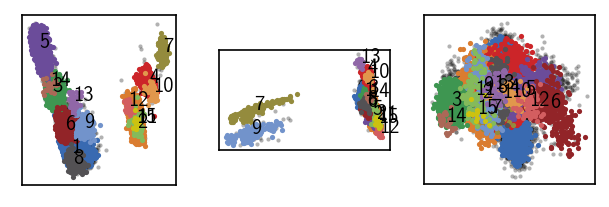

In [97]:
draw_evaluate(langerin)

In [98]:
print("Label    Size")
print("=============")
print(*sorted({k: len(v) for k, v in langerin._labels.mapping.items()}.items()), sep="\n")

Label    Size
(0, 5437)
(1, 8169)
(2, 4206)
(3, 2767)
(4, 2526)
(5, 1922)
(6, 497)
(7, 225)
(8, 207)
(9, 200)
(10, 117)
(11, 112)
(12, 57)
(13, 46)
(14, 26)
(15, 14)


For later re-use, we can remember the clustering parameters leading to the isolation of each cluster and save the cluster labels.

In [110]:
np.save("md_example/langerin_labels.npy", langerin.labels)

In [100]:
print("Label", "r", "n", sep="\t")
print("-" * 20)
for k, v in sorted(langerin._labels.meta["params"].items()):
    print(k, *v, sep="\t")

Label	r	n
--------------------
1	1.5	984
2	1.5	7
3	1.5	984
4	1.5	3
5	1.5	132
6	1.5	30
7	1.5	3
8	1.5	3
9	1.5	3
10	1.5	3
11	1.5	3
12	1.5	7
13	1.5	3
14	1.5	3
15	1.5	3


## MSM estimation

Assuming our data was sampled in a time-correlated manner as it is the case for MD simulation data, we can use this clustering result as a basis for the estimation of a core-set Markov-state model.

In [7]:
from csmsm.estimator import CoresetMarkovStateModel

In [8]:
langerin = cluster.Clustering(
    np.load("md_example/langerin_projection.npy", allow_pickle=True),
    alias="C-type lectin langerin"
    )

In [9]:
langerin.labels = np.load("md_example/langerin_labels.npy")

In [11]:
M = CoresetMarkovStateModel(langerin.to_dtrajs(), unit="ns", step=1)

TypeError: __init__() got an unexpected keyword argument 'unit'

In [251]:
# Estimate csMSM for different lag times (given in steps)
lags = [1, 2, 4, 8, 15, 30]
for i in lags:
    M.cmsm(lag=i, minlenfactor=5, v=False)
    M.get_its()

[(0.0, 10459.606311240232)]

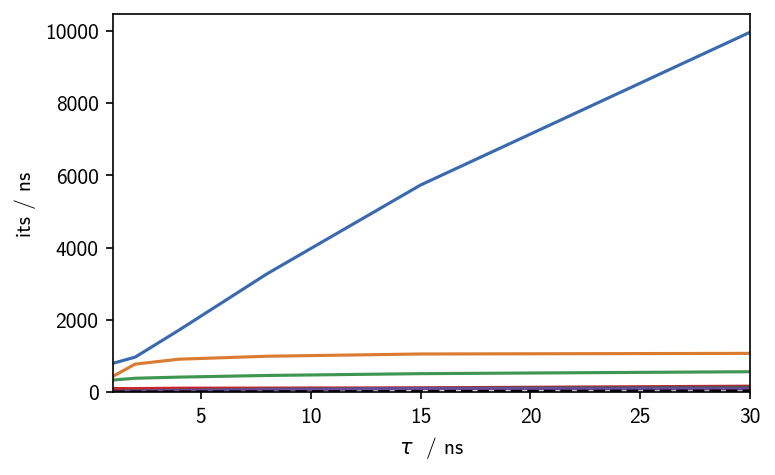

In [252]:
# Plot the time scales
fig, ax, *_ = M.plot_its()
fig.tight_layout(pad=0.1)
ax.set(**{
    "ylim": (0, None)
})

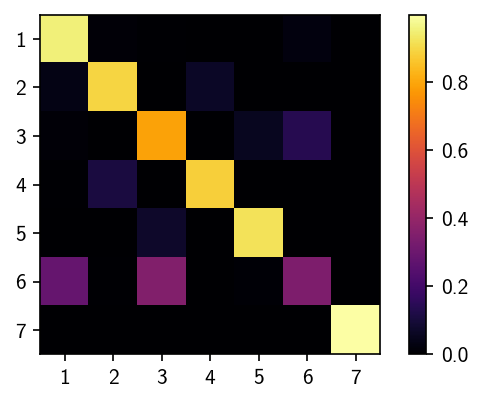

In [224]:
fig, ax = plt.subplots()
matrix = ax.imshow(M.T, cmap=mpl.cm.inferno)
fig.colorbar(matrix)
ax.set(**{
    "aspect": "equal",
    "xticks": range(len(M.T)),
    "xticklabels": range(1, len(M.T) + 1),
    "yticks": range(len(M.T)),
    "yticklabels": range(1, len(M.T) + 1)
})
plt.show()

## Prediction

In [134]:
# Lets make sure we work on the correctly clustered object
print("Label", "r", "c", sep="\t")
print("-" * 20)
for k, v in sorted(langerin_reduced.labels.info.params.items()):
    print(k, *v, sep="\t")

Label	r	c
--------------------
1	0.19	15
2	0.4	5
3	0.25	15
4	0.4	5
5	0.375	10
6	0.375	10
7	0.19	15
8	0.19	15
9	0.5	5
10	0.5	5
11	0.5	5
12	0.5	5
13	0.375	10
14	0.375	10
15	0.5	5
16	0.19	15
17	0.25	15


In [142]:
langerin_reduced_less = langerin.cut(points=(None, None, 50))

In [143]:
langerin_reduced_less.calc_dist(langerin_reduced, mmap=True, mmap_file="/home/janjoswig/tmp/tmp.npy", chunksize=1000)  # Distance map calculation

MemoryError: Unable to allocate 10.5 GiB for an array with shape (52942, 26528) and data type float64

## Cluster alternatives

It is always recommended to cross validate a clustering result with the outcome of other clustering approaches. We want to have a quick look at the alternative that density-peak clustering provides.

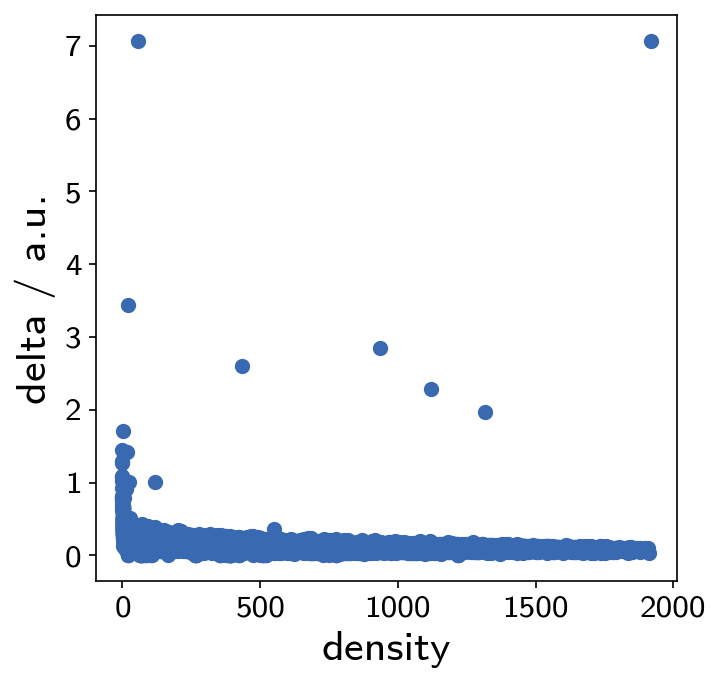

In [61]:
pydpc_clustering = pydpc.Cluster(langerin_reduced.data.points)

Clustering in this case is just a single step without the need of parameter specification. In the following, however, we need to extract the actual clusters by looking at the plot below. Points that are clearly isolated in this plot are highly reliable cluster centers.

In [65]:
pydpc_clustering.autoplot = True

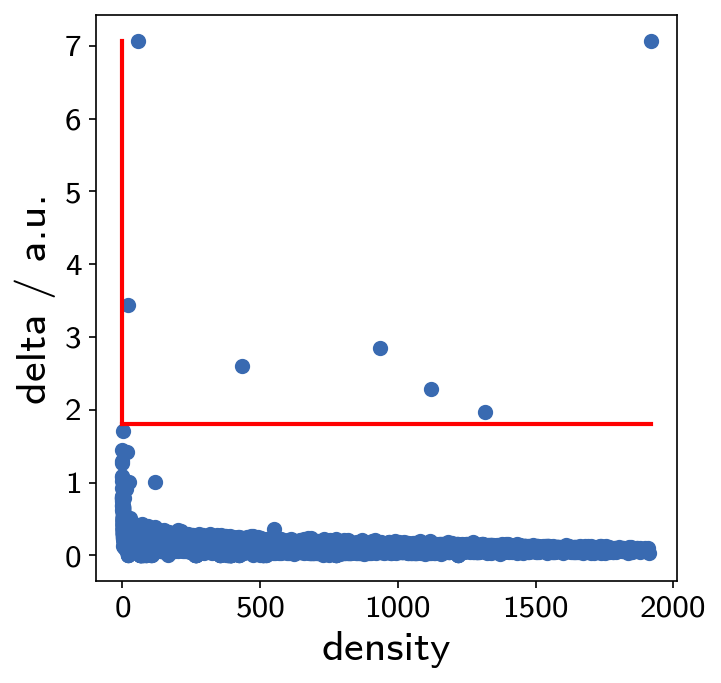

In [66]:
pydpc_clustering.assign(0, 1.8)

This gives us 7 clusters.

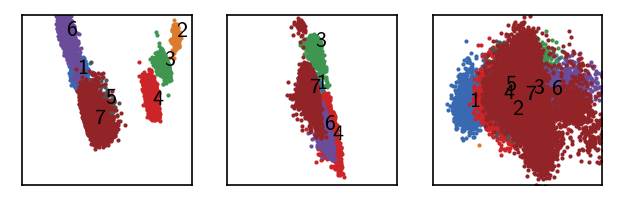

In [70]:
langerin_reduced.labels = (pydpc_clustering.membership + 1)
draw_evaluate(langerin_reduced)

As we are interested in core clusters we want to apply the core/halo criterion to disregard points with low cluster membership probabilitie as noise.

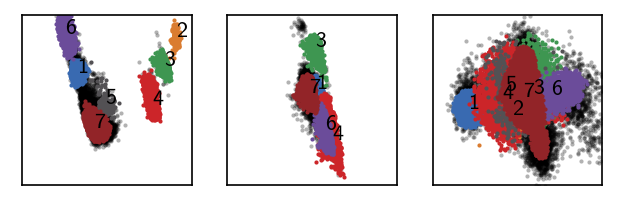

In [71]:
langerin_reduced.labels[pydpc_clustering.halo_idx] = 0
draw_evaluate(langerin_reduced)

In [72]:
M = cmsm.CMSM(langerin_reduced.get_dtraj(), unit="ns", step=1)

In [73]:
# Estimate csMSM for different lag times (given in steps)
lags = [1, 2, 4, 8, 15, 30]
for i in lags:
    M.cmsm(lag=i, minlenfactor=5)
    M.get_its()


*********************************************************
---------------------------------------------------------
Computing coreset MSM at lagtime 1 ns
---------------------------------------------------------

Using 116 trajectories with 25900 steps over 7 coresets

All sets are connected
---------------------------------------------------------
*********************************************************


*********************************************************
---------------------------------------------------------
Computing coreset MSM at lagtime 2 ns
---------------------------------------------------------

Using 116 trajectories with 25900 steps over 7 coresets

All sets are connected
---------------------------------------------------------
*********************************************************


*********************************************************
---------------------------------------------------------
Computing coreset MSM at lagtime 4 ns
-----------------------

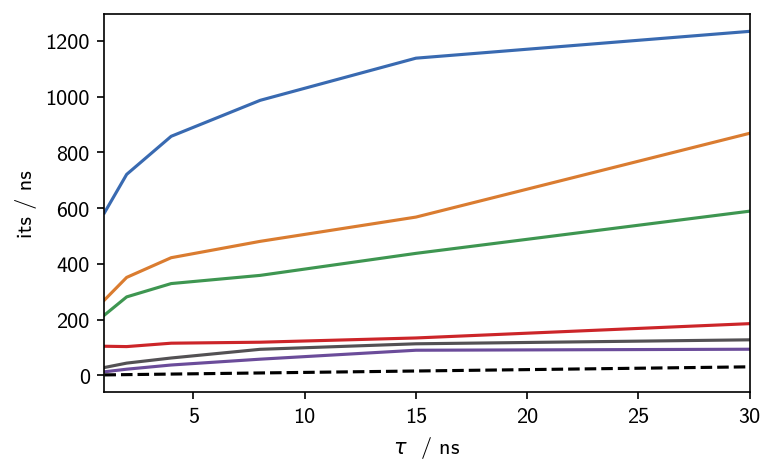

In [74]:
# Plot the time scales
fig, ax, *_ = M.plot_its()
fig.tight_layout(pad=0.1)

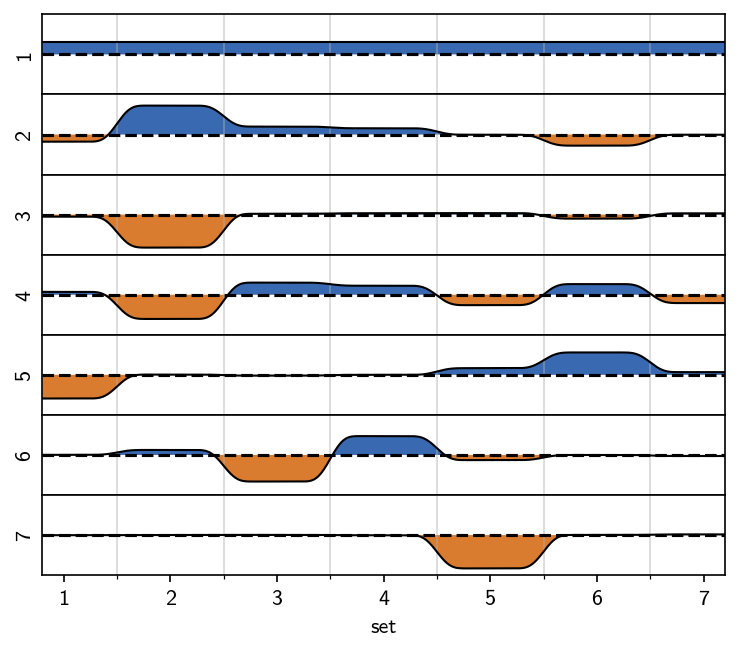

In [75]:
figsize = mpl.rcParams["figure.figsize"]
mpl.rcParams["figure.figsize"] = figsize[0], figsize[1] * 0.2
M.plot_eigenvectors()
mpl.rcParams["figure.figsize"] = figsize

This result is in good agreement with the one we obtained manually and argualbe faster and easier to achieve. If we decide that this result is exactly what we consider valid, then this is nice. If we on the other hand want to tune the clustering result further, with respect to splitting, noise level and what is considered noise in the first place we gain more flexibility with the manual approach.